# **RNN Alt sequences**

In [28]:
import torch
import torch.nn as nn
import numpy as np
import sys
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-28-70b6d9ff5a8e>:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


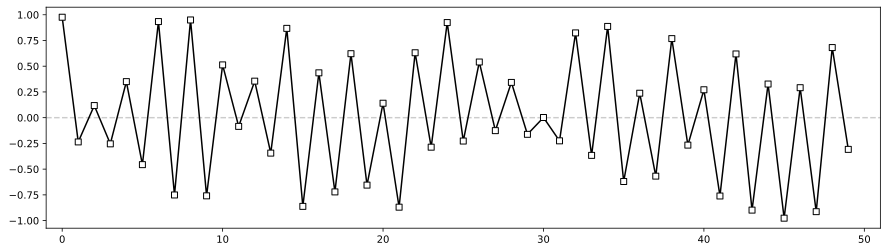

In [29]:
N = 50
data = torch.zeros(N)
for i in range(N):
  data[i] = torch.rand(1) * (-1)**i
plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

In [30]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    self.out = nn.Linear(num_hidden,1)
  def forward(self, x):
    y,hidden = self.rnn(x) 
    y = self.out(y)
    return y,hidden
input_size = 1 
num_hidden = 5 
num_layers = 1
seqlength = 9 
batchsize = 1



```
input_size = 1 
num_hidden = 5 
num_layers = 1
seqlength = 9 
batchsize = 2 #change batch size
```



In [31]:
net = rnnnet(input_size,num_hidden,num_layers)
X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) 
print(h.shape)
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata)
finalValue = y[0][-1]
lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])
tensor(0.8985, grad_fn=<MeanBackward0>)




```
net = rnnnet(input_size, num_hidden, num_layers)
X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X)
print(X.shape)
print(y.shape) 
print(h.shape)

somedata = data[:seqlength].view(seqlength, 1, 1)
y = net(somedata)
finalValue = y[0][-1]

lossfun = nn.L1Loss()  # Changing the loss function to L1 Loss
loss = lossfun(finalValue, data[seqlength].view(1,1))
print(loss)

we changed the loss function from nn.MSELoss() to nn.L1Loss(). nn.L1Loss() is the mean absolute error between the predicted value and the actual value. 

```



**Training the model & Performance metrics**

In [32]:
numepochs = 30
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)
for epochi in range(numepochs):
  seglosses = []  
  segacc = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) 
  for timei in range(N-seqlength):
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    seglosses.append(loss.item())
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*(truesign==predsign)
    segacc.append(accuracy)

  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)
truesign

Finished epoch 30/30

-1.0

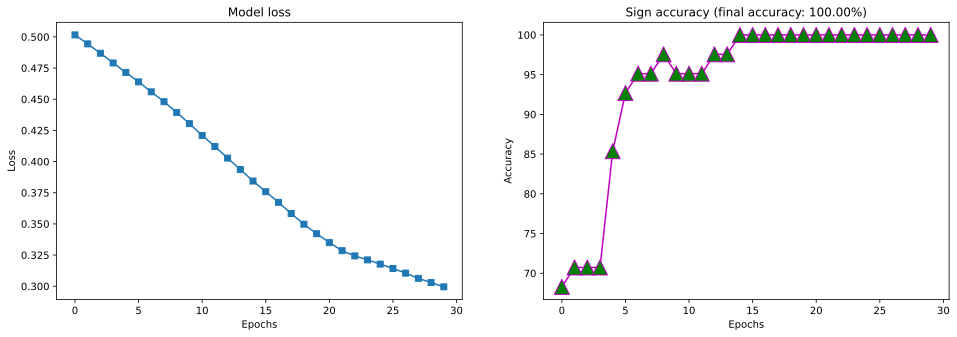

In [33]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])
plt.show()

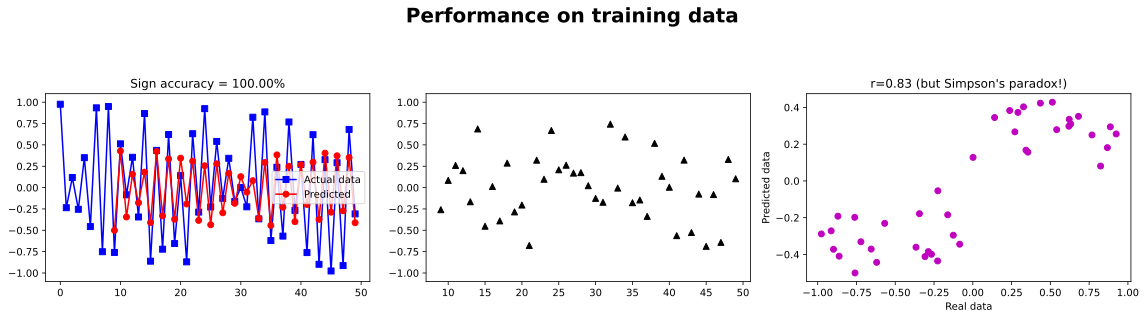

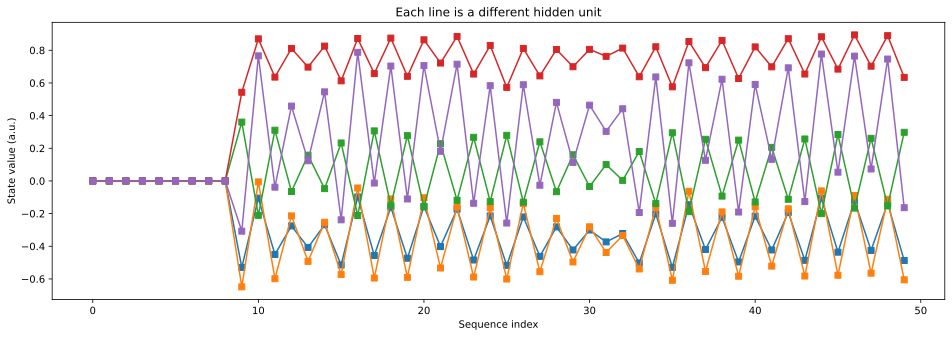

In [34]:
h = np.zeros((N,num_hidden))
yHat = np.zeros(N)
yHat[:] = np.nan
for timei in range(N-seqlength):
  X = data[timei:timei+seqlength].view(seqlength,1,1)
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()
ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")
plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()
plt.figure(figsize=(16,5))
plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

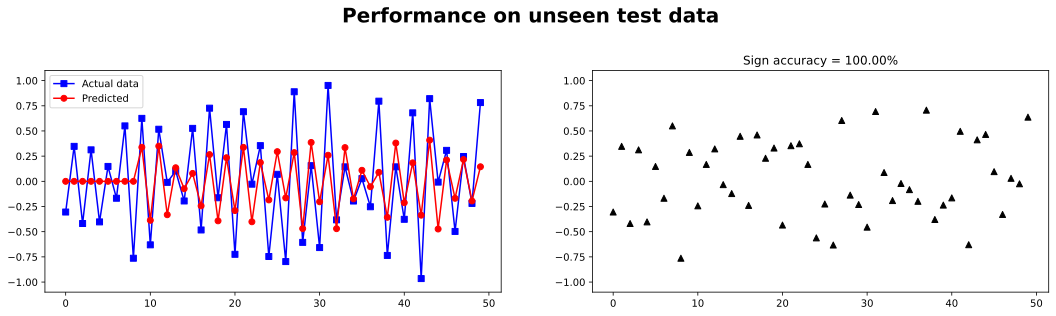

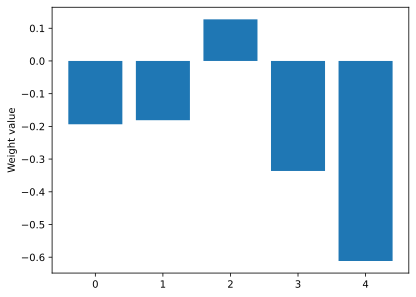

In [35]:
newdata = torch.zeros(N)
for i in range(N):
  newdata[i] = torch.rand(1) * (-1)**(i+1)
h = np.zeros((N,num_hidden))
yHat = np.zeros(N)
for timei in range(N-seqlength):
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])
fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()
ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)
plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()